# Cats Vs. Dogs
### Eden Trainor


#### Imports


In [62]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as skl

#making things pretty
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 #Image resizing
import os
from tqdm import tqdm

from sklearn.utils import shuffle as mutual_shuffle
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator


#### Load Data

Global Variable setting:


In [4]:
USER_NAME = 'EdenTrainor' #Configure this with your username
DATA_REPO = 'C:/Users/{}/Datalytyx/Delivery - Documents/Data Science/Data/'.format(USER_NAME)

#Path of actual image JPGs
TRAIN_IMAGES_FOLDER = '{}Cat_VS_Dog/all/train_images/'.format(DATA_REPO)
TEST_IMAGES_FOLDER = '{}Cat_VS_Dog/all/test_images/'.format(DATA_REPO)

#Path of images as resized arrays
TRAIN_ARRAYS_FOLDER = '{}Cat_VS_Dog/all/train_arrays/'.format(DATA_REPO)
TEST_ARRAYS_FOLDER = '{}Cat_VS_Dog/all/test_arrays/'.format(DATA_REPO)


#Images will be resized to a square of size:
IMAGE_SIZE = 64
EVAL_SPLIT_SIZE = 5000




Create function to parse images into list of arrays and extract labels from image names

In [5]:
#Function to parse labels from image files

def label_parser(img_path):
    #get label from image name: e.g. dog.93.jpg
    word_label = img_path.split('.')[0]
    
    
    #One Hot the labels
    if word_label == 'dog': 
        return [1, 0]
    
    elif word_label == 'cat': 
        return [0, 1]
    
    # Deal with exceptions but don't stop process.
    else: 
        print('Unable to parse label for {}'.format(img_path))

        
        
def create_train_data():
    train_images = []
    train_labels = []
    
    for img in tqdm(os.listdir(TRAIN_IMAGES_FOLDER)):
        
        #Label the image
        label = label_parser(img)
        
        
        path = os.path.join(TRAIN_IMAGES_FOLDER, img)
        
        img = cv2.imread(path)
        
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        
        train_images.append(img)
        train_labels.append(label)
    
    #Stack images
    train_images = np.stack(train_images, axis = 0)
    train_labels = np.stack(train_labels, axis = 0)    
   
    np.save('{}train_images-{}.npy'.format(TRAIN_ARRAYS_FOLDER, IMAGE_SIZE), train_images)
    np.save('{}train_labels-{}.npy'.format(TRAIN_ARRAYS_FOLDER, IMAGE_SIZE), train_labels)
    
    return train_images, train_labels
        
    

For first time runs, or for changing image sizes, run the below cell:

In [6]:
#train_images, train_labels = create_train_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:06<00:00, 378.65it/s]


For reloading the kernel we'll just load up the arrays we saved

In [8]:
train_images = np.load('{}train_images-{}.npy'.format(TRAIN_ARRAYS_FOLDER, IMAGE_SIZE))
train_labels = np.load('{}train_labels-{}.npy'.format(TRAIN_ARRAYS_FOLDER, IMAGE_SIZE))

Do the same for test data. But just export to array.

In [6]:
def process_test_data():
    test_data = []
    
    for img in tqdm(os.listdir(TEST_IMAGES_FOLDER)):
        
        path = os.path.join(TEST_IMAGES_FOLDER, img)
        
        img_num = img.split('.')[0]
        
        img = cv2.imread(path)
        
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        
        test_data.append([img, img_num])
    
    test_data = np.stack(test_data, axis = 0)
        
    np.save('{}test_images-{}.npy'.format(TEST_ARRAYS_FOLDER, IMAGE_SIZE), test_data)

In [7]:
#process_test_data()

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:31<00:00, 401.73it/s]


Split data into train/eval features/labels and shuffle the data.

In [9]:
train_X, eval_X, train_y, eval_y = train_test_split(train_images, train_labels,
                                                    random_state = 0,
                                                    test_size = 0.2)

### Experimental Data Analysis

Lets look at some of our images:

In [10]:
from random import randint

In [17]:
randint(0, 25000)

18105

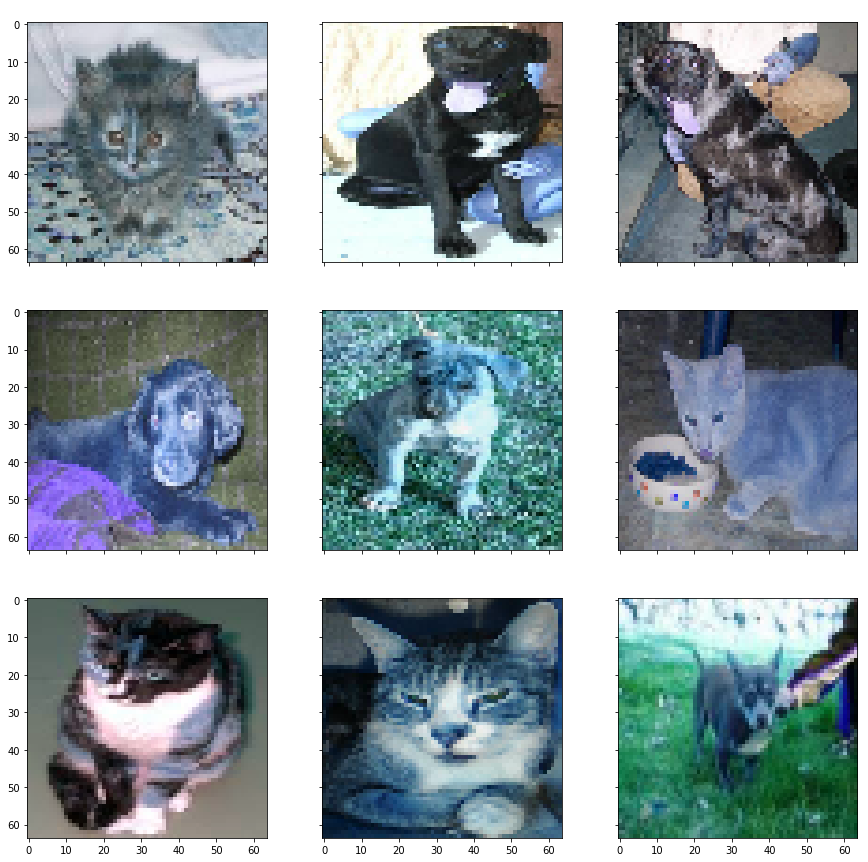

In [34]:
#Plot a few of the images
fig, ax = plt.subplots(3, 3,
                      sharex='col', 
                      sharey='row', 
                      figsize=(15, 15))

label_set = np.array(['cat', 'dog'])

for i in range(3):
    for j in range(3):
        
        #pick random image
        
        img_index = randint(0, train_y.shape[0])
        ax[i, j].imshow(train_X[img_index])

        ax[i, j].set_title('{} - index: {}'.format(label_set[train_y[img_index][0]], img_index), color = 'w')
        

Look at the distribution of target classes in dataset

In [20]:
print('Number of dogs in training set {}, number of cats in training set {}'.format(train_y[:,0].sum(), train_y[:,1].sum()))

Number of dogs in training set 9996, number of cats in training set 10004


In [21]:
print('Number of dogs in evaluation set {}, number of cats in evaluation set {}'.format(eval_y[:,0].sum(), eval_y[:,1].sum()))

Number of dogs in evaluation set 2504, number of cats in evaluation set 2496


#### Edge Detection Filters

In [40]:
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage import feature

Look at image through 4 edge detection filters, filters work on grayscale images.

In [41]:
test_image = train_X[0]
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

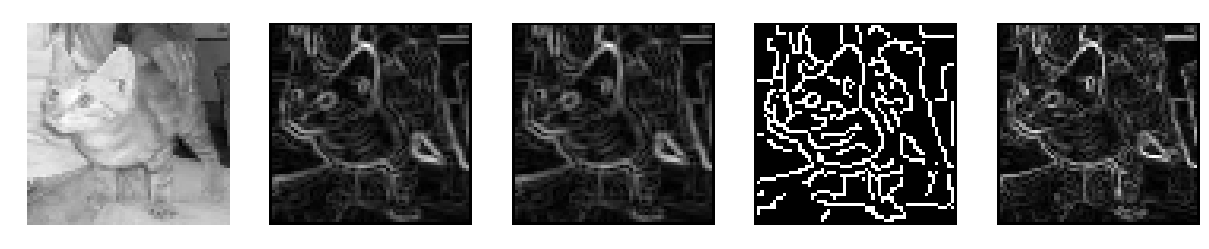

In [45]:
def edge_filter_plots(test_img):    
    
    edge_canny = feature.canny(test_img)
    edge_roberts = roberts(test_img)
    edge_sobel = sobel(test_img)
    edge_prewitt = prewitt(test_img)

    fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=(21, 10.5))

    ax[0].imshow(test_img, cmap=plt.cm.gray)
    ax[0].set_title('Test Image', color = 'w')

    ax[1].imshow(edge_sobel, cmap=plt.cm.gray)
    ax[1].set_title('Sobel Edge Detection', color = 'w')

    ax[2].imshow(edge_prewitt, cmap=plt.cm.gray)
    ax[2].set_title('Prewitt Filter', color = 'w')

    ax[3].imshow(edge_canny, cmap=plt.cm.gray)
    ax[3].set_title('Canny Filter', color = 'w')

    ax[4].imshow(edge_roberts, cmap=plt.cm.gray)
    ax[4].set_title('Roberts Edge Detection', color = 'w')

    for a in ax:
        a.axis('off')
        
        
edge_filter_plots(test_image)

### Preprocessing

Look at image normalization

In [91]:
#Use a transformer for this bit for the sake of reusability
class ImageNormalizer(TransformerMixin, BaseEstimator):
    """
    A normalizer for RGB/Greyscale images, either batch or stream.
    images must be in numpy arrays of the shape (batch_size, img_shape[1], img_shape[2], channels)
    """
    
    def __init__(self, mode = 'batch'):
        """
        Mode can dictate normalization per: 'image', 'channel', or 'batch'
        """
        
        self.mode = mode
        
    def fit(self, X, y = None):
        """
        Description
        -----------
        No fitting on dataset, images are normalized per image.
        
        Authors
        -------
        Eden Trainor
        """
        return self
    
    def transform(self, X):
        """
        Description
        -----------
        Calculate means/std for each channel of each image and normalize using these values.
        
        Args
        ----
        X: np.ndarray, (batch_size, img_shape[1], img_shape[2], channels)
            Array of numpy arrays with same image shapes and number of channels each.
            
        Returns
        -------
        norm_X: np.ndarray, (batch_size, img_shape[1], img_shape[2], channels)
            Array of normalized images.
        """
        
        assert isinstance(X, np.ndarray)
        
        if self.mode == 'channel':
            #Calculate mean per image, per channel
            mus = np.mean(X, axis = (1, 2))

            #Calculate standard deviation per image, per channel
            sigmas = np.std(X, axis = (1, 2))

            #Take away 
            norm_X = (X -  mus[ :, None, None, :]) / sigmas[ :, None, None, :]

            return norm_X
        
        
        elif self.mode == 'batch':

            #Calculate mean per image, per batch
            mus = np.mean(X, axis = (1, 2, 3))

            #Calculate standard deviation per image, per batch
            sigmas = np.std(X, axis = (1, 2, 3))

            #Take away 
            norm_X = (X -  mus[ :, None, None, None]) / sigmas[ :, None, None, None]

            return norm_X
        
        
        elif self.mode == 'image':
            
            #Calculate mean per image, per batch
            mus = np.mean(X, axis = (1, 2))

            #Calculate standard deviation per image, per batch
            sigmas = np.std(X, axis = (1, 2))

            #Take away 
            norm_X = (X -  mus[ :, None, None, :]) / sigmas[ :, None, None, :]

            return norm_X
    
    def fit_transform(self, X, y = None):
        """
        Combines the fit and transform methods of this class
        """
        return self.fit(X, y).transform(X)
        
        

In [128]:
to_norm = train_X[0:4]

mus = np.mean(to_norm, axis = (1, 2, 3))

sigmas = np.std(to_norm, axis = (1, 2, 3))

In [130]:
normed = (to_norm -  mus[ :, None, None, None]) / sigmas[ :, None, None, None]

In [131]:
normed[0].std()

1.0

In [103]:
normalized_images = PerChannelImageNormalizer().fit_transform(train_X[0:3])

In [139]:
normed[0, :, :, 1]

array([[ 1.36867601,  1.55144489,  1.49052193, ..., -0.8448582 ,
        -0.31685922, -0.82455055],
       [ 1.40929131,  1.51082958,  1.44990662, ..., -1.04793473,
        -0.60116636, -0.70270463],
       [ 1.51082958,  1.53113723,  1.49052193, ..., -1.29162657,
        -1.10885769, -0.78393524],
       ...,
       [ 0.1096015 ,  0.29237038,  0.23144742, ...,  0.96252294,
         0.98283059,  0.96252294],
       [ 0.35329334,  0.35329334,  0.25175508, ...,  0.94221529,
         0.96252294,  0.96252294],
       [ 0.23144742,  0.23144742,  0.29237038, ...,  0.98283059,
         1.04375355,  0.94221529]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


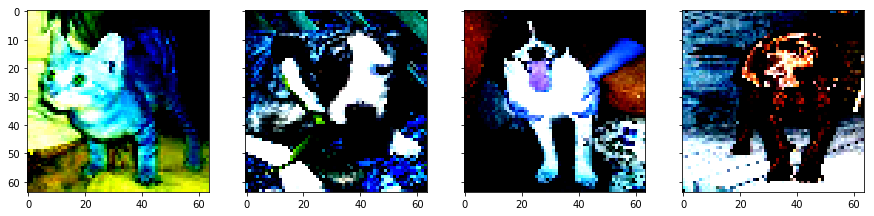

In [138]:
fig, ax = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (15, 7))

for indx, image in enumerate(normed):
    ax[indx].imshow(image, cmap = 'brg')